## Input Arguments

Available at your playlist page:
> [https://open.spotify.com/playlist/**37i9dQZEVXbMDoHDwVN2tF**](https://open.spotify.com/playlist/37i9dQZEVXbMDoHDwVN2tF)

This is **Top 50 - Global** playlist

In [115]:
# Rock Classics
playlist_id = "37i9dQZF1DWXRqgorJj26U"

In [116]:
# Top 50 Global
playlist_id = "37i9dQZEVXbMDoHDwVN2tF"

In [117]:
# Esquenta Sertanejo
playlist_id = "37i9dQZF1DXdSjVZQzv2tl"

## Spotify API initialization

In [118]:
%%capture

!pip install spotipy

load your client id and client secret for the Spotify API

In [119]:
import spotify_secrets

In [120]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials

scope = "user-library-read playlist-modify-private"
OAuth = SpotifyOAuth(
        scope=scope,         
        redirect_uri='http://localhost:5000/callback',
        client_id = spotify_secrets.OAuth['client_id'],
        client_secret = spotify_secrets.OAuth['client_secret'])

client_credentials_manager = SpotifyClientCredentials(client_id = OAuth.client_id, client_secret = OAuth.client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

## Libraries

In [121]:
import pandas as pd
import re

import urllib.request, urllib.error
import requests
import bs4

from bs4 import BeautifulSoup

## Capturing the playlist tracks

In [122]:
dict_songs = {
    "song-title": [],
    "artist": [],
}

In [123]:
playlist = sp.playlist(playlist_id)

songs = playlist['tracks']['items']

for song in songs:
  dict_songs["song-title"].append(song['track']['name'])
  dict_songs["artist"].append(song['track']['artists'][0]['name'])

In [124]:
df_songs = pd.DataFrame(dict_songs)

In [125]:
df_songs['link-letras'] = ''
df_songs['raw-lyrics'] = ''
df_songs['google-url'] = ''

In [126]:
df_songs

,song-title,artist,link-letras,raw-lyrics,google-url
0,A Culpa É Nossa - Ao Vivo,Maiara & Maraisa,,,
1,Traumatizei - Ao Vivo Em Brasília,Henrique & Juliano,,,
2,Não Vitalício (Nunca Mais) - Ao Vivo,Matheus & Kauan,,,
3,Leão,Marília Mendonça,,,
4,Nosso Quadro,AgroPlay,,,
5,Quando Apaga A Luz - Ao Vivo,Gustavo Mioto,,,
6,Bombonzinho - Ao Vivo,Israel & Rodolffo,,,
7,Erro Gostoso - Ao Vivo,Simone Mendes,,,
8,Duas Três,Guilherme & Benuto,,,
9,Média Boa - Ao Vivo,Felipe e Rodrigo,,,


## Functions to format words

In [127]:
def format_word(nome):

  nome = nome.replace(" ", r"%20")
  nome = nome.lower()

  # substitui caracteres de acentos pelos seus sem acento
  nome = nome.replace("ç", "c")
  nome = nome.replace("ñ", "n")
  nome = re.sub(r"[áàâã]","a", nome)
  nome = re.sub(r"[éèê&]","e", nome)
  nome = re.sub(r"[íî]","i", nome)
  nome = re.sub(r"[óòôõ]","o", nome)
  nome = re.sub(r"[úùû]","u", nome)

  nome = re.sub(r"-{2,}","-", nome)

  return str(nome)

def create_google_partial_link(artista, musica):
  artista = format_word(artista)
  musica = format_word(musica)
  return artista + r"%20" + musica

## Capture link of Letras website

In [128]:
def get_link_letras(href_tag):

  letras_suffix_url = 'https://www.letras.+'
  regex_letras_link = letras_suffix_url + "/" + ".+/" + ".+/"
  matches = re.findall(regex_letras_link, href_tag)

  if len(matches) > 0:
      return matches[0]

  return False

In [129]:
https_failures = 0
links_letras_captured = 0

for id, row in df_songs.iterrows():

  link_google_parcial = create_google_partial_link(row['artist'], row['song-title'])

  url = 'https://www.google.com/search?q=Letras%20MUS%20' + link_google_parcial
  df_songs['google-url'][id] = url

  try:
    request_result=requests.get(url)
    soup = bs4.BeautifulSoup(request_result.text, "html.parser")

    all_aTags = soup.findAll('a')
    for aTag in all_aTags:
        link_letras = get_link_letras(aTag['href'])

        if link_letras:
          links_letras_captured += 1
          break
        else:
          link_letras = "#"

  except urllib.error.HTTPError as err:
    link_letras = '#'
    print('HTTP', err.code, 'ERROR')
    https_failures += 1

  df_songs['link-letras'][id] = link_letras

print("Number of https failures: " + str(https_failures))
print("number of captured lyric's links: " + str(links_letras_captured))

Number of https failures: 0
number of captured lyric's links: 50


## capture all songs lyrics

In [130]:
https_failures = 0
lyrics_captured = 0

for id, linha in df_songs.iterrows():

  url = linha['link-letras']

  try:
    request_result=requests.get(url)
    soup = bs4.BeautifulSoup(request_result.text, "html.parser")

    raw_lyrics = soup.find('div', {"class":"cnt-letra"})

    lyrics_captured += 1

  except:
    raw_lyrics = '-'
    print('ERROR')
    https_failures +=  1

  df_songs['raw-lyrics'][id] = raw_lyrics

print("Number of https failures: " + str(https_failures))
print("number of captured lyrics: " + str(lyrics_captured))

Number of https failures: 0
number of captured lyrics: 50


## Treating Lyrics

In [131]:
df_songs= df_songs.astype('string')

### Removing HTML tags

In [132]:
def sub_by_space(textos, regex):
    if type(textos) == str:
        return regex.sub(" ", textos)
    else:
        return [regex.sub(" ", texto) for texto in textos]

def lower_case(textos):
    if type(textos) == str:
        return textos.lower()
    else:
        return [texto.lower() for texto in textos]

def apply_strip(textos):
    if type(textos) == str:
        return textos.strip()
    else:
        return [texto.strip() for texto in textos]

In [133]:
regex_html = re.compile(r"<.*?>")
lyrics_without_HTMLtags = sub_by_space(df_songs['raw-lyrics'], regex_html)

regex_doubleSpaces = re.compile(r"\s{2,}")
lyrics_without_HTMLtags_doubleSpace = sub_by_space(lyrics_without_HTMLtags, regex_doubleSpaces)

lyrics_lowerCase_without_HTMLtags_doubleSpace = lower_case(lyrics_without_HTMLtags_doubleSpace)

lyrics_lowerCase_strip_without_HTMLtags_doubleSpace = apply_strip(lyrics_lowerCase_without_HTMLtags_doubleSpace)





In [134]:
df_songs["treatment-1"] = lyrics_lowerCase_strip_without_HTMLtags_doubleSpace

In [135]:
from string import punctuation

import nltk
from nltk import tokenize

token_punctuation = tokenize.WordPunctTokenizer()

processed_lyrics = list()

for lyrics in df_songs['treatment-1']:
  new_lyrics = list()
  lyrics_tokenized = token_punctuation.tokenize(lyrics)

  for word in lyrics_tokenized:
    if word not in punctuation:
      new_lyrics.append(word)
  
  processed_lyrics.append(' '.join(new_lyrics))

df_songs["treatment-2"] = processed_lyrics

## Plotting first Cloud

In [136]:
%matplotlib inline

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordCloud(series_lyrics):
  all_words = ' '.join([texto for texto in series_lyrics])

  MyWordCloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

  import matplotlib.pyplot as plt

  plt.figure(figsize=(15,10))
  plt.imshow(MyWordCloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

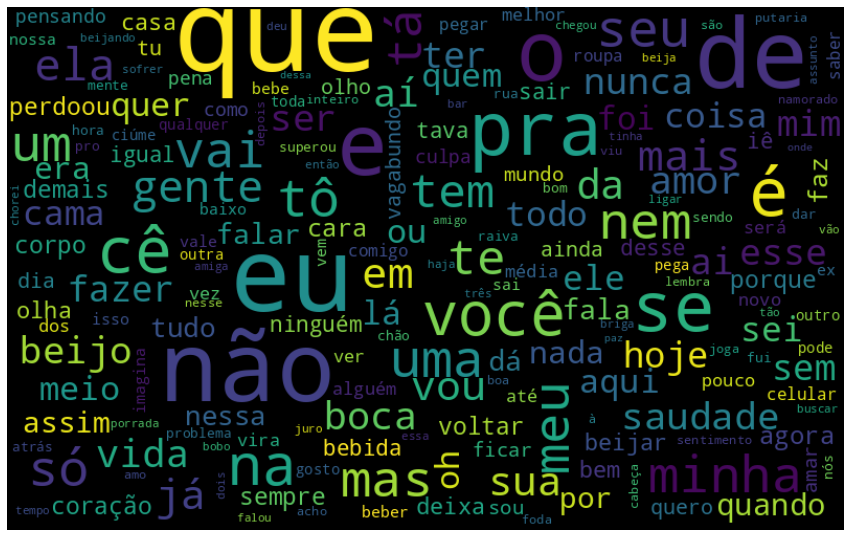

In [137]:
create_wordCloud(df_songs['treatment-1'])

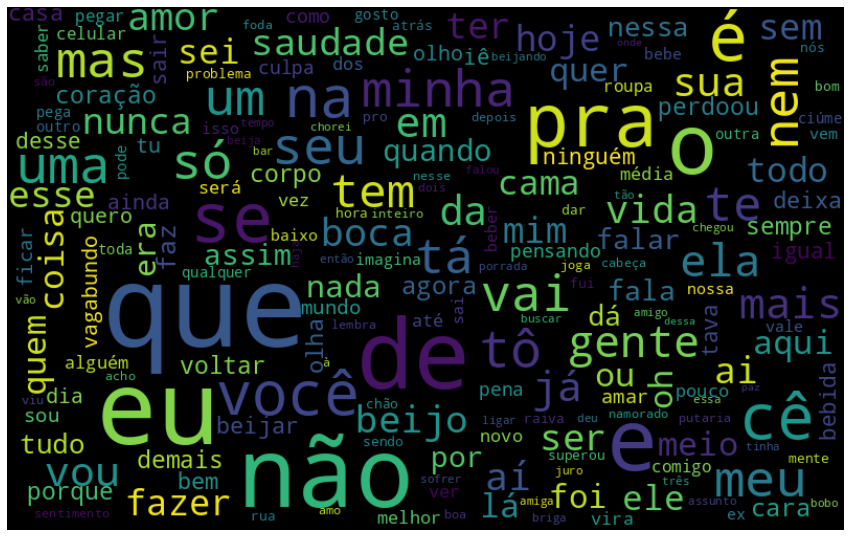

In [138]:
create_wordCloud(df_songs['treatment-2'])